# Handwriting recognition
# Import libraries

In [1]:
# Warning python version < 3.12.0( 3.8.10 recommended)

import os
import cv2
import sys
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from setuptools import setup # use instead of distutils(deprecated)
import tensorflow as tf
# from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
print(tf.config.list_physical_devices("CPU"))
print(tf.config.list_physical_devices("GPU"))


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load data

In [3]:
train = pd.read_csv('written_name_train_v2.csv')
valid = pd.read_csv('written_name_validation_v2.csv')
test = pd.read_csv('written_name_test_v2.csv')

train_len = len(train)
test_len = len(test)
validation_len = len(valid)

sum = train_len + test_len + validation_len

print("train data:  {:.2f}  {}".format((train_len/ sum), train_len))
print("valid data:  {:.2f}  {}".format((validation_len / sum), validation_len))
print("test data:   {:.2f}  {}".format((test_len / sum), test_len))

train data:  0.80  330961
valid data:  0.10  41370
test data:   0.10  41370


#  View data

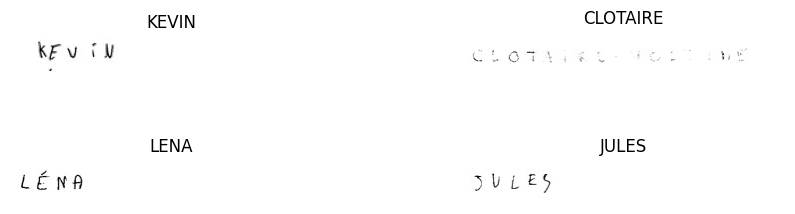

In [4]:
plt.figure(figsize=(10, 10))

for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    img_dir = './test_v2/test/' + test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    plt.title(test.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.4, hspace=-0.8)
plt.show()

# Clean data

In [5]:
print("Number of NaNs in train set      : ", train.IDENTITY.isna().sum())
print("Number of NaNs in validation set : ", valid.IDENTITY.isna().sum())
print("Number of NaNs in validation set : ", test.IDENTITY.isna().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78
Number of NaNs in validation set :  70


In [6]:
# Drop the NaNs labels
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)

In [7]:
# Remove the Unreadable labels
train = train[train.IDENTITY != 'UNREADABLE']
valid = valid[valid.IDENTITY != 'UNREADABLE']
test = test[test.IDENTITY != 'UNREADABLE']

In [8]:
# Covert lowercase to uppercase
train.IDENTITY = train.IDENTITY.str.upper()
valid.IDENTITY = valid.IDENTITY.str.upper()
test.IDENTITY = test.IDENTITY.str.upper()

In [9]:
# Reset the index
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)
test.reset_index(inplace = True, drop=True)

In [11]:
train_size = len(train)# train 5000 images 
#test_size = len(test)
valid_size = 5000#len(valid)# train 620 images

In [12]:
valid_batch_size = 620
train_batch_size = 5000
print(train_size, valid_size)

330294 5000


# Preprocess the images

In [13]:
# Fuction to preprocess the img
def preprocess(img):
    (h, w) = img.shape                                    # Getting the height & width of the image
    
    final_img = np.ones([64, 256])*255                    # Blank white image
    
    # crop    
    if h > 64:
        img = img[:64, :]                                 # If the h>64 then it is cropped to 64
        
    if w > 256:
        img = img[:, :256]                                # If the w>256 then it is cropped to 256
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE) # Rotate 90° Clockwise & return

Preprocess & save test data

In [27]:
train_x = []

for i in range(train_size):
    img_dir = './train_v2/train/' + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    train_x.append(image)
    
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1} images")

print("Processing complete.")

Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processing complete.


In [76]:
# Split the train_x array into batches of train_batch_size images each
batch_size = train_batch_size
num_batches = len(train_x) // batch_size
remainder = len(train_x) % batch_size

start_idx = 0
for i in range(num_batches):
    end_idx = start_idx + batch_size
    # Extract a batch of images
    batch_images = train_x[start_idx:end_idx]
    # Reshape the batch into the required format (num_images, height, width, channels)
    batch_images = np.array(batch_images).reshape(-1, 256, 64, 1)

    # Create a folder for the current batch
    folder_path = os.path.join('dataset', f'{i + 1}')

    # Save the batch to a .npy file
    filename = os.path.join(folder_path, f'train_x.npy')
    np.save(filename, batch_images)

    start_idx = end_idx
    
    print(i+1)

# Process the remaining images
if remainder > 0:
    # Extract the remaining images
    batch_images = train_x[start_idx:]
    # Reshape the remaining images into the required format
    batch_images = np.array(batch_images).reshape(-1, 256, 64, 1)
    # Create a folder for the remaining images
    folder_path = os.path.join('dataset', f'{num_batches + 1}')
    os.makedirs(folder_path, exist_ok=True)
    # Save the remaining images to a .npy file
    filename = os.path.join(folder_path, f'train_x.npy')
    np.save(filename, batch_images)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


In [28]:
# Convert 'train_x' to a NumPy array and reshape it
train_x = np.array(train_x).reshape(-1, 256, 64, 1)

# np.save('preprocessed_train_v2', train_x)
# train_x = np.load('preprocessed_train_v2.npy')

Preprocess & save valid data

In [14]:
valid_x = []

for i in range(valid_size):
    img_dir = './validation_v2/validation/' + valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    valid_x.append(image)
    
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1} images")

print("Processing complete.")

Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processing complete.


In [70]:
# Split the valid_x array into batches of valid_batch_size images each
batch_size = valid_batch_size
num_batches = len(valid_x) // batch_size
remainder = len(valid_x) % batch_size

start_idx = 0
for i in range(num_batches):
    end_idx = start_idx + batch_size
    # Extract a batch of images
    batch_images = valid_x[start_idx:end_idx]
    # Reshape the batch into the required format (num_images, height, width, channels)
    batch_images = np.array(batch_images).reshape(-1, 256, 64, 1)

    # Create a folder for the current batch
    folder_path = os.path.join('dataset', f'{i + 1}')
    os.makedirs(folder_path, exist_ok=True)

    # Save the batch to a .npy file
    filename = os.path.join(folder_path, f'valid_x.npy')
    np.save(filename, batch_images)

    start_idx = end_idx

    print(i+1)
# Process the remaining images
if remainder > 0:
    # Extract the remaining images
    batch_images = valid_x[start_idx:]
    # Reshape the remaining images into the required format
    batch_images = np.array(batch_images).reshape(-1, 256, 64, 1)
    # Create a folder for the remaining images
    folder_path = os.path.join('dataset', f'{num_batches + 1}')
    os.makedirs(folder_path, exist_ok=True)
    # Save the remaining images to a .npy file
    filename = os.path.join(folder_path, f'valid_x.npy')
    np.save(filename, batch_images)

In [15]:
# Convert 'valid_x' to a NumPy array and reshape it
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)
# np.save('preprocessed_validation_v2', valid_x)
# valid_x = np.load('preprocessed_validation_v2')

# Data Label Preprocess
In this section of the code, we perform data label preprocessing for a text recognition task. The goal is to convert text labels into a numerical format for use in train a neural network. Let's break down the key components of this preprocess:

Character Set and Constants
* alphabets: This string represents the set of valid characters that can appear in the text labels. It includes uppercase letters, hyphen, and space.

* max_str_len: This constant defines the maximum length of the input labels.

* num_of_characters: The number of unique characters, including an extra one for the CTC pseudo-blank character.

* num_of_timestamps: The maximum length of predicted labels.

# Label-to-Number Conversion
* label_to_num(label): This function converts a text label to a numerical representation. It initializes an empty list to store character indices and iterates over each character in the input label. For each character, it finds the index in the alphabets string and appends it to the list. The function returns a NumPy array with the numerical representation of the label.
* Number-to-Label Conversion
num_to_label(num): This function converts a list of numerical values back to a text label. It iterates over each character index in the input list, checks for the CTC blank character (-1), and appends the corresponding character from alphabets to the output string.

# Initialization of Arrays
Several arrays are initialized to store the preprocessed labels and related information for both training and validation datasets. These include:

* train_y: An array to store the converted labels for the training dataset.

* train_label_len: An array to store the length of labels for each data point in the training dataset.

* train_input_len: An array to store the input length for each data point in the training dataset.

* train_output: An array to store training data outputs (usually used for CTC loss).

# Data Processing
A loop is used to process both the training and validation datasets. Within the loop:

* The 'IDENTITY' value from the dataset is retrieved and converted to a string if it's not already.

* The label length is set and label values are stored in the corresponding arrays (train_y for training and valid_y for validation).

In [19]:
alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "  # The set of valid characters
max_str_len = 34                             # Maximum length of input labels
num_of_characters = len(alphabets) + 1       # Number of unique characters, plus 1 for CTC pseudo-blank
num_of_timestamps = 64                       # The maximum length of predicted labels

In [20]:
def label_to_num(label):
    return np.array([alphabets.find(ch) for ch in label])

In [21]:
def num_to_label(num):
    return ''.join([alphabets[ch] for ch in num if ch != -1])

In [22]:
# Example
name = 'TATIA'
name_num = label_to_num(name)
print(name_num,'\n', num_to_label(name_num))

[19  0 19  8  0] 
 TATIA


In [107]:
blank_label = -1

In [36]:
# Initialize arrays
train_y = np.ones([train_size, max_str_len]) * blank_label
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps - 2)
train_output = np.zeros([train_size])

# Loop through the training data
for i in range(train_size):
    # Get the 'IDENTITY' value and convert it to a string if it's not already
    identity = train.loc[i, 'IDENTITY']
    if not isinstance(identity, str):
        identity = str(identity)
    
    # Set the label length and label values in train_y
    train_label_len[i] = len(identity)
    
    # Assuming label_to_num is a function that converts characters to numerical values
    train_y[i, 0:len(identity)] = label_to_num(identity)

In [70]:
batch_size = train_batch_size

# Iterate through each folder
for i in range(1, 67):
    folder_path = os.path.join('dataset', str(i))

    batch_train_y = np.ones([batch_size, max_str_len]) * blank_label
    batch_train_label_len = np.zeros([batch_size, 1])
    batch_train_input_len = np.ones([batch_size, 1]) * (num_of_timestamps - 2)
    batch_train_output = np.zeros([batch_size])
    
    # Loop through the training data
    for j in range(batch_size):
        # Get the 'IDENTITY' value and convert it to a string if it's not already
        identity = train.loc[(batch_size * (i-1)) + j, 'IDENTITY']
        if not isinstance(identity, str):
            identity = str(identity)
        
        # Set the label length and label values in train_y
        batch_train_label_len[j] = len(identity)
        
        # Assuming label_to_num is a function that converts characters to numerical values
        batch_train_y[j, 0:len(identity)] = label_to_num(identity)

    # Save data in the folder
    np.save(os.path.join(folder_path, 'train_y.npy'), batch_train_y)
    np.save(os.path.join(folder_path, 'train_label_len.npy'), batch_train_label_len)
    np.save(os.path.join(folder_path, 'train_input_len.npy'), batch_train_input_len)
    np.save(os.path.join(folder_path, 'train_output.npy'), batch_train_output)
    
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


In [60]:
# Initialize arrays for validation data
valid_y = np.ones([valid_size, max_str_len]) * blank_label
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps - 2)
valid_output = np.zeros([valid_size])

# Loop through the validation data
for i in range(valid_size):
    # Get the 'IDENTITY' value and convert it to a string if it's not already
    identity = valid.loc[i, 'IDENTITY']
    if not isinstance(identity, str):
        identity = str(identity)
    
    # Set the label length and label values in valid_y
    valid_label_len[i] = len(identity)
    
    # Assuming label_to_num is a function that converts characters to numerical values
    valid_y[i, 0:len(identity)] = label_to_num(identity)

BILEL
LAUMIONIER
LEA
JEAN-ROCH
RUPP
PICHON
DANIEL
JEREMY
JEAN-MICHEL
JULIEN
NAEL
BILGER
TIFFANY
ELEEN
ANTOINE
AYOUB
MINETTE
RAINGEVAL
CELESTIN
DIBENEDETTO
MATHIS
LOUNA
SEVESTRE
DAVANLAY
HOCQUARD
LEBRUN
DABIN
SENDOUBI
DI PASQUALE
PRIVAT
HUGO
MAONI
COTTIGNY
SARRAZIN
FRERE
MONSOH
BELMERROUBICARRO
CLEMENT
ALLEMBRAND
CASSANORA
VIEILLE
VAUTIER
LOUISE
DUTARR ICR
ENNIO
ALYSSIA
RUIZ
LIZANA
CAMILLE
JULIE
ELIA
AXEL
ANTOINE
NION
RICHARD
COONAC
DAVOULT
SAAD
DUBOIS
NAU
JULIEN
BENET
DAVID
THOMAS
VAILLANT
JOAO
LYLOU
CARA
TABUT
PELLETIER
AUTRET
CHECROUN
VASSEUR
FAURE
EMMA
ARTHUR
FRIMIN
ANAELLE
DYEAN
RAPHEL
VANTOMME
OMNES
ANTOINE
ANDRANIK
LUCAS
CELIA
LOURENCO
MAYLIS
LUCIE
DEBARD
DEPAQUY
VERHILLE
SORRESE
HUGO
CRUSSIERE
THEANA
LEDROLE
BERNARD
VALENTINE
GABRIELLE
CLOE
BONNE
ELGUOFA
MORGANE
ROZENN
DYLAN
ANTHONY
LEA
WALID
HEDDEBAUX
LUCAS
TEO
DEMEESTERE
CAGGANDRO
CHIO
DO ROSARIO
JAHIER
DIANA
FRENOT
VIDAL
COMBE
PERITO
CHIPRET
CAMPOLO
EL FETOUVAKI
JUSTIN
SPLENE
GEHAN
LOU-ANNE
LEITAO PEREIRA
AXEL
HOUDOT-HERRING


In [71]:
batch_size = valid_batch_size

# Iterate through each folder
for i in range(1, 67):
    folder_path = os.path.join('dataset', str(i))

    batch_valid_y = np.ones([batch_size, max_str_len]) * blank_label
    batch_valid_label_len = np.zeros([batch_size, 1])
    batch_valid_input_len = np.ones([batch_size, 1]) * (num_of_timestamps - 2)
    batch_valid_output = np.zeros([batch_size])
    
    # Loop through the training data
    for j in range(batch_size):
        # Get the 'IDENTITY' value and convert it to a string if it's not already
        identity = valid.loc[((batch_size * (i-1)) + j), 'IDENTITY']
        if not isinstance(identity, str):
            identity = str(identity)
        # Set the label length and label values in train_y
        batch_valid_label_len[j] = len(identity)
        
        # Assuming label_to_num is a function that converts characters to numerical values
        batch_valid_y[j, 0:len(identity)] = label_to_num(identity)

    # Save data in the folder
    np.save(os.path.join(folder_path, 'valid_y.npy'), batch_valid_y)
    np.save(os.path.join(folder_path, 'valid_label_len.npy'), batch_valid_label_len)
    np.save(os.path.join(folder_path, 'valid_input_len.npy'), batch_valid_input_len)
    np.save(os.path.join(folder_path, 'valid_output.npy'), batch_valid_output)
    
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


In [17]:
print('True label : ',train.loc[4, 'IDENTITY'] , '\ntrain_y : ',train_y[4],'\ntrain_label_len : ',train_label_len[4], 
      '\ntrain_input_len : ', train_input_len[4])

NameError: name 'train_y' is not defined


# Build The Model

# Convolutional Recurrent Neural Network (CRNN) Architecture¶
In this code snippet, we define a Convolutional Recurrent Neural Network (CRNN) model for processing grayscale images with a shape of (256, 64, 1). This architecture combines both convolutional and recurrent layers, making it suitable for various tasks, such as text recognition in images.

Let's break down the components of this model:

# Input Layer
The model starts with an input layer that is designed to accept grayscale images with dimensions of 256x64 pixels.

# Convolutional Layers
* Convolutional Layer 1: This layer applies 32 filters with a (3, 3) kernel, 'same' padding, and He normal initialization. It is followed by batch normalization, ReLU activation, and max-pooling with a (2, 2) pool size.

* Convolutional Layer 2: Similar to the first layer, but with 64 filters.

* Convolutional Layer 3: This layer has 128 filters, followed by batch normalization, ReLU activation, and max-pooling with a (1, 2) pool size. Dropout with a rate of 0.3 is also applied.

# Reshape Layer
After the convolutional layers, the output is reshaped to have a target shape of (64, 1024). This reshaped output is then fed into the recurrent layers.

# Fully Connected Layer¶
A fully connected layer with 64 units and ReLU activation is applied to the reshaped output.

# Bidirectional LSTM Layers
Two bidirectional Long Short-Term Memory (LSTM) layers with 256 units each are used. These layers return sequences and are essential for handling sequential data, making them suitable for tasks like text recognition.

# Output Layer
The output layer consists of a dense layer with the number of characters as the output units. The softmax activation function is applied to produce probabilities for each character in the output sequence.

# Model Creation
The model is created using the Keras Functional API, with the input and output layers specified.

# Model Summary¶
Finally, the code provides a summary of the model architecture, displaying the layers, their shapes, and the number of parameters.

In [41]:
#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.disable_v2_behavior()
#comet com
#model.run_eagerly = False
#tf.compat.v1.experimental.output_all_intermediates(True)

Instructions for updating:
non-resource variables are not supported in the long term


In [23]:
# Define the input layer with a shape of (256, 64, 1) for grayscale images
input_data = Input(shape=(256, 64, 1), name='input')

# Convolutional Layer 1: 32 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)                         # Batch normalization
inner = Activation('relu')(inner)                           # ReLU activation
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # Max-pooling

# Convolutional Layer 2: 64 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)  
inner = Activation('relu')(inner)     
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  
inner = Dropout(0.3)(inner)

# Convolutional Layer 3: 128 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)                         
inner = Activation('relu')(inner)                           
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  
inner = Dropout(0.3)(inner)                                 

# Reshape the output for sequence processing
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)

# Fully Connected Layer 1: 64 units, ReLU activation, He normal initialization
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# Bidirectional LSTM Layers: 256 units, return sequences
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# Output Layer: Number of characters, He normal initialization
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)  # Softmax activation

In [24]:
# Create the model with input and output layers
model = Model(inputs=input_data, outputs=y_pred)

model.load_weights('trained_model_12_3.h5')

In [25]:
# Display a summary of the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization_3 (Batc  (None, 256, 64, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

Compute the CTC loss between predicted and true labels.

In [26]:
# The ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # The 2 is critical here since the first couple outputs of the RNN tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [27]:
# Define input placeholders for true labels, input sequence length, and label sequence length
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# Calculate CTC loss using the ctc_lambda_func function
ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# Create the final model that takes input data, true labels, input length, and label length
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [28]:
# Compile the final model with a dummy loss lambda function (loss calculation occurs elsewhere)
# The optimizer used is Adam with a learning rate of 0.0001
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))
history = []

# Train the Model

In [143]:
# Define the folder to save the model
checkpoint_dir = 'checkpoints/'
# Create the folder if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)  # Stop training if val_loss does not improve
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_{epoch:02d}_{val_loss:.3f}.h5'),  # Path to the model file to be saved
    monitor='val_loss',  # Monitor val_loss
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model when val_loss is at its minimum
)

# Iterate through each folder
for i in range(30, 31):
    folder_path = os.path.join('dataset', str(i))
    
    # Load data from files in the folder
    train_x = np.load(os.path.join(folder_path, 'train_x.npy'))
    train_y = np.load(os.path.join(folder_path, 'train_y.npy'))
    train_input_len = np.load(os.path.join(folder_path, 'train_input_len.npy'))
    train_label_len = np.load(os.path.join(folder_path, 'train_label_len.npy'))
    train_output = np.load(os.path.join(folder_path, 'train_output.npy'))

    valid_x = np.load(os.path.join(folder_path, 'valid_x.npy'))
    valid_y = np.load(os.path.join(folder_path, 'valid_y.npy'))
    valid_input_len = np.load(os.path.join(folder_path, 'valid_input_len.npy'))
    valid_label_len = np.load(os.path.join(folder_path, 'valid_label_len.npy'))
    valid_output = np.load(os.path.join(folder_path, 'valid_output.npy'))

    # Train the model with the current data
    print("dataset ", i)
    history_buff = model_final.fit(
        x=[train_x, train_y, train_input_len, train_label_len],
        y=train_output,
        validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
        epochs=20,
        batch_size=64,
        callbacks=[early_stopping_callback, checkpoint_callback]
    )
    
    # Load the best model from the checkpoint
    #best_model_path = tf.train.latest_checkpoint(checkpoint_dir)
    #model_final.load_weights(best_model_path)
    
    history.extend(history_buff.history['loss'])
    history.extend(history_buff.history['val_loss']) 
    
     # Delete variables to free up memory
    del train_x, train_y, train_input_len, train_label_len, train_output
    del valid_x, valid_y, valid_input_len, valid_label_len, valid_output


dataset  30
Epoch 1/20
79/79 [==============================] - 18s 155ms/step - loss: 1.2759 - val_loss: 1.1298
Epoch 2/20
79/79 [==============================] - 11s 138ms/step - loss: 1.0862 - val_loss: 1.1496
Epoch 3/20
38/79 [=============>................] - ETA: 5s - loss: 0.8931

KeyboardInterrupt: 

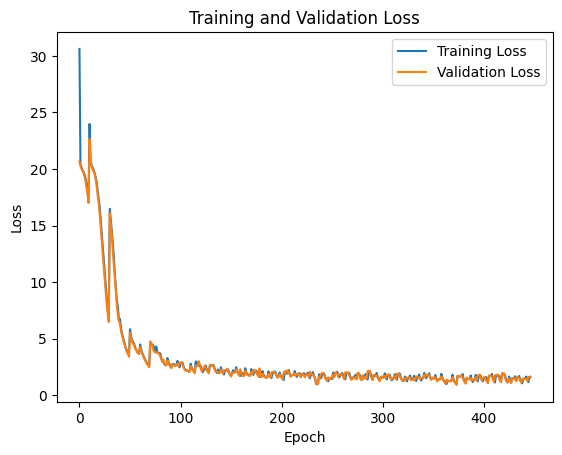

In [19]:
#  loss and val_loss history
loss = history[::2]
val_loss = history[1::2]

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [167]:
# Save model 
model.save('trained_model_12_3.h5')

INFO:tensorflow:Assets written to: last_trained_model\assets


INFO:tensorflow:Assets written to: last_trained_model\assets


In [87]:
# save history
with open('history12.pkl', 'wb') as file:
    pickle.dump(history, file)

[]


In [72]:
#Load model
model = load_model('trained_model.h12')

In [29]:
preds = model.predict(valid_x)
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

157/157 [==============================] - 12s 29ms/step


In [31]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 89.98%
Correct words predicted      : 79.74%


In [32]:
# 50.88 38.83  model 10
# 86.98 75.59  model 11
# 89.08 77.78  model 11.1 in ram memory
# 89.98 79.74  model 12_3

# Prediction on Test Set

1/1 [==============================] - 0s 34ms/step


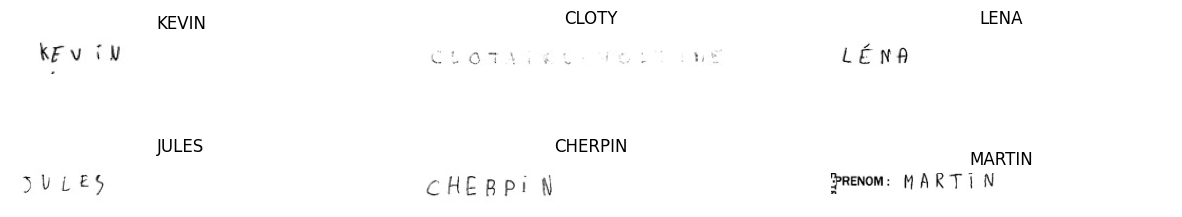

In [33]:
test = pd.read_csv('written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = './test_v2/test/'+ test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [34]:
# Initialize variables to track correct characters
correct_characters = 0
total_characters = 0
max_images = 100  # Specify the number of images to evaluate

# Iterate through the test set
for i in range(min(len(test), max_images)):
    # Get the ground truth label
    ground_truth = test.loc[i, 'IDENTITY']
    
    # Preprocess and predict the image using your model
    img_dir = './test_v2/test/' + test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image / 255.0
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
    predicted_label = num_to_label(decoded[0])
    
     # Calculate character-level accuracy
    for j in range(min(len(ground_truth), len(predicted_label))):
        if ground_truth[j] == predicted_label[j]:
            correct_characters += 1
        total_characters += 1
        
    print(i)

# Calculate character-level accuracy
character_level_accuracy = (correct_characters / total_characters) * 100

1/1 [==============================] - 0s 46ms/step
0
1/1 [==============================] - 0s 42ms/step
1
1/1 [==============================] - 0s 44ms/step
2
1/1 [==============================] - 0s 43ms/step
3
1/1 [==============================] - 0s 52ms/step
4
1/1 [==============================] - 0s 46ms/step
5
1/1 [==============================] - 0s 44ms/step
6
1/1 [==============================] - 0s 49ms/step
7
1/1 [==============================] - 0s 44ms/step
8
1/1 [==============================] - 0s 48ms/step
9
1/1 [==============================] - 0s 44ms/step
10
1/1 [==============================] - 0s 43ms/step
11
1/1 [==============================] - 0s 41ms/step
12
1/1 [==============================] - 0s 45ms/step
13
1/1 [==============================] - 0s 45ms/step
14
1/1 [==============================] - 0s 46ms/step
15
1/1 [==============================] - 0s 44ms/step
16
1/1 [==============================] - 0s 45ms/step
17
1/1 [===============

In [35]:
print('Character-Level Accuracy for {} images: {:.2f}%'.format(max_images, character_level_accuracy))

Character-Level Accuracy for 100 images: 93.21%


In [137]:
# 11.1 87.73
# 11.2 89.61
# 12 90.90
# 12_2 92.35
# 12_3 93.21  92.87 93.37

In [142]:
# Initialize a dictionary to track errors for each character
character_errors = {}
max_images = 500
# Iterate through the test set
for i in range(min(len(test), max_images)):
    # Get the ground truth label
    ground_truth = test.loc[i, 'IDENTITY']
    
    # Preprocess and predict the image using your model
    img_dir = './test_v2/test/' + test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image / 255.0
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
    predicted_label = num_to_label(decoded[0])
    
    # Calculate errors for each character
    for j in range(min(len(ground_truth), len(predicted_label))):
        if ground_truth[j] != predicted_label[j]:
            if ground_truth[j] not in character_errors:
                character_errors[ground_truth[j]] = 1
            else:
                character_errors[ground_truth[j]] += 1
                
# Print characters with the most errors
sorted_errors = sorted(character_errors.items(), key=lambda x: x[1], reverse=True)
print("Character\tErrors")
for char, errors in sorted_errors:
    print(f"{char}\t{errors}")


1/1 [==============================] - 0s 65ms/step
Character	Errors
E	31
R	25
A	23
T	17
O	16
D	15
L	15
I	14
N	13
M	13
S	12
U	11
H	10
V	8
P	6
C	6
Y	5
G	4
 	4
B	4
-	2
Z	2
Q	2
J	2
F	1
W	1


In [71]:
print(sorted_errors)

[('I', 21), ('E', 21), ('R', 20), ('A', 15), ('O', 15), ('M', 14), ('S', 13), ('D', 13), ('N', 12), ('T', 10), ('L', 8), ('U', 8), ('V', 7), ('Y', 7), ('H', 6), ('P', 4), ('C', 4), (' ', 4), ('Z', 3), ('B', 3), ('Q', 2), ('J', 2), ('-', 1), ('F', 1), ('G', 1), ('K', 1), ('W', 1)]


In [89]:

first_12_chars = sorted_errors[0][0][:17]

train_indexes = []
valid_indexes = []


for idx, row in train.iterrows():
    count = row['IDENTITY'][:12].count(first_12_chars)
    if count > 2:
        train_indexes.append(idx)

for idx, row in valid.iterrows():
    count = row['IDENTITY'][:12].count(first_12_chars)
    if count > 2:
        valid_indexes.append(idx)

print("Train indexes with more than 2 occurrences of the first 12 characters:", train_indexes)
print("Validation indexes with more than 2 occurrences of the first 12 characters:", valid_indexes)


Train indexes with more than 2 occurrences of the first 12 characters: [15, 102, 136, 558, 675, 753, 1259, 1499, 1616, 1759, 1773, 1800, 2220, 3290, 3388, 3855, 6007, 7411, 7517, 8237, 8362, 8714, 8724, 8747, 8862, 9094, 9362, 9881, 10259, 10268, 10680, 11150, 11342, 11418, 11600, 12234, 12396, 13026, 13092, 13407, 13419, 13880, 14047, 14064, 14419, 14679, 15004, 15718, 15909, 16088, 16241, 16410, 16571, 16661, 16732, 16996, 19705, 19746, 19833, 20231, 20316, 20710, 20748, 21741, 21864, 22002, 22094, 22270, 24395, 24832, 24922, 25036, 25327, 25419, 26551, 26759, 26968, 27264, 27763, 28206, 28556, 28786, 29033, 29158, 29327, 29395, 29811, 30419, 30450, 30817, 31464, 32373, 32673, 33190, 33371, 33571, 33652, 34352, 34527, 34650, 34738, 34824, 34962, 35027, 35067, 35498, 36993, 37382, 37426, 37586, 37591, 37611, 38064, 38261, 39113, 39615, 39902, 39965, 40111, 40653, 40923, 41680, 41736, 42133, 42184, 42476, 43167, 43918, 44019, 45420, 46583, 46657, 48716, 48995, 49353, 49377, 49916, 5051

In [104]:
train_indexes_size = len(train_indexes)
print(train_indexes_size)

937


In [105]:
valid_indexes_size = len(valid_indexes)
print(valid_indexes_size)

118


In [95]:
train_x = []

for i in train_indexes:
    img_dir = './train_v2/train/' + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    train_x.append(image)
    
    
print(f"Processed {len(train_indexes)} images")

print("Processing complete.")

Processed 937 images
Processing complete.


In [98]:
# create new data set 66

# Reshape the batch into the required format (num_images, height, width, channels)
train_x = np.array(train_x).reshape(-1, 256, 64, 1)

# Create a folder for the current batch
folder_path = os.path.join('dataset', f'{66}')

# Save the batch to a .npy file
filename = os.path.join(folder_path, f'train_x.npy')
np.save(filename, train_x)

In [100]:
valid_x = []

for i in valid_indexes:
    img_dir = './validation_v2/validation/' + valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    valid_x.append(image)
    
print(f"Processed {len(valid_x)} images")

Processed 118 images


In [101]:
# create new data set 66

# Reshape the batch into the required format (num_images, height, width, channels)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

# Create a folder for the current batch
folder_path = os.path.join('dataset', f'{66}')

# Save the batch to a .npy file
filename = os.path.join(folder_path, f'valid_x.npy')
np.save(filename, valid_x)

In [109]:
# Initialize arrays
train_y = np.ones([train_indexes_size, max_str_len]) * blank_label
train_label_len = np.zeros([train_indexes_size, 1])
train_input_len = np.ones([train_indexes_size, 1]) * (num_of_timestamps - 2)
train_output = np.zeros([train_indexes_size])

# Loop through the training data
i = 0
for idx in train_indexes:
    # Get the 'IDENTITY' value and convert it to a string if it's not already
    identity = train.loc[idx, 'IDENTITY']
    if not isinstance(identity, str):
        identity = str(identity)
    
    # Set the label length and label values in train_y
    train_label_len[i] = len(identity)
    
    # Assuming label_to_num is a function that converts characters to numerical values
    train_y[i, 0:len(identity)] = label_to_num(identity)
    i = i + 1

In [110]:
# Save data in the folder
folder_path = 'dataset/66'

np.save(os.path.join(folder_path, 'train_y.npy'), train_y)
np.save(os.path.join(folder_path, 'train_label_len.npy'), train_label_len)
np.save(os.path.join(folder_path, 'train_input_len.npy'), train_input_len)
np.save(os.path.join(folder_path, 'train_output.npy'), train_output)

In [111]:
# Initialize arrays
valid_y = np.ones([valid_indexes_size, max_str_len]) * blank_label
valid_label_len = np.zeros([valid_indexes_size, 1])
valid_input_len = np.ones([valid_indexes_size, 1]) * (num_of_timestamps - 2)
valid_output = np.zeros([valid_indexes_size])

# Loop through the training data
i = 0
for idx in valid_indexes:
    # Get the 'IDENTITY' value and convert it to a string if it's not already
    identity = valid.loc[idx, 'IDENTITY']
    if not isinstance(identity, str):
        identity = str(identity)
    
    # Set the label length and label values in train_y
    valid_label_len[i] = len(identity)
    
    # Assuming label_to_num is a function that converts characters to numerical values
    valid_y[i, 0:len(identity)] = label_to_num(identity)
    i = i + 1

In [112]:
# Save data in the folder
folder_path = 'dataset/66'

np.save(os.path.join(folder_path, 'valid_y.npy'), valid_y)
np.save(os.path.join(folder_path, 'valid_label_len.npy'), valid_label_len)
np.save(os.path.join(folder_path, 'valid_input_len.npy'), valid_input_len)
np.save(os.path.join(folder_path, 'valid_output.npy'), valid_output)